# Assignment 3

- KNN classification on Spam dataset

- Newton's Methods to solve Logistic Regression

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression

# KNN classification on Spam dataset

## Spam dataset Background

Spam dataset: a collection of 57 features relating to about 4600 emails and a label of whether or not the email is considered spam. 

a training set: containing about 70% of the data

a test set:  containing about 30% of the data. 

goal: spam classification

- Features

    The column names (in the first row of each .csv file) are fairly self-explanatory.

    Some variables are named `word_freq_(word)`, which suggests a calculation of the frequency of how many times a specific word appears in the email, expressed as a percentage of total words in the email multiplied by $100$.

    Some variables are named `char_freq_(*)`, which suggests a count of the frequency of the specific ensuing character, expressed as a percentage of total characters in the email multiplied by $100$.

    Some variables are named `capital_run_length_(*)` which suggests some information about the average (or maximum length of, or total) consecutive capital letters in the email.

- Response: `spam`  0 = not spam, 1 = spam.

In [4]:
loc = '/Users/wenxinxu/Desktop/SDS565/data/spam/'
dftr = pd.read_csv(loc+'spam_train_withlabels.csv',header=0)
dfte = pd.read_csv(loc+'spam_test_nolabels.csv',header=0)

In [5]:
dftr.columns

Index(['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_freq_addresses', 'word_freq_free',
       'word_freq_business', 'word_freq_email', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
       'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
       'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_conference',


In [6]:
merged_train_test = pd.concat([dftr.drop('spam',axis=1), dfte])

In [7]:
merged_train_test.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,0.00,0.1,0.00,0.0,0.10,0.21,0.00,0.10,0.0,0.00,...,0.0,0.000,0.047,0.000,0.000,0.031,0.0,1.793,12,391
1,0.00,0.0,0.29,0.0,0.00,0.00,0.00,0.00,0.0,0.00,...,0.0,0.000,0.178,0.000,0.044,0.000,0.0,-500.000,10,180
2,0.47,0.0,0.95,0.0,0.95,0.00,0.95,0.00,0.0,0.00,...,0.0,0.000,0.076,0.000,1.306,0.230,0.0,6.027,91,217
3,0.00,0.0,0.37,0.0,1.11,0.74,0.00,2.96,0.0,2.96,...,0.0,0.000,0.149,0.000,1.096,0.000,0.0,5.160,107,289
4,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,...,0.0,0.634,0.000,0.211,0.000,0.211,0.0,1.347,4,31


## Missing Values and outliers

an NA or `np.nan` represent missing values. **DO NOT DELETE THEM**

In [10]:
merged_train_test.isna().sum().sort_values(ascending=False)

capital_run_length_average    404
word_freq_make                  0
word_freq_original              0
word_freq_857                   0
word_freq_data                  0
word_freq_415                   0
word_freq_85                    0
word_freq_technology            0
word_freq_1999                  0
word_freq_parts                 0
word_freq_pm                    0
word_freq_direct                0
word_freq_cs                    0
word_freq_meeting               0
word_freq_project               0
word_freq_labs                  0
word_freq_re                    0
word_freq_edu                   0
word_freq_table                 0
word_freq_conference            0
char_freq_;                     0
char_freq_(                     0
char_freq_[                     0
char_freq_!                     0
char_freq_$                     0
char_freq_#                     0
capital_run_length_longest      0
word_freq_telnet                0
word_freq_lab                   0
word_freq_addr

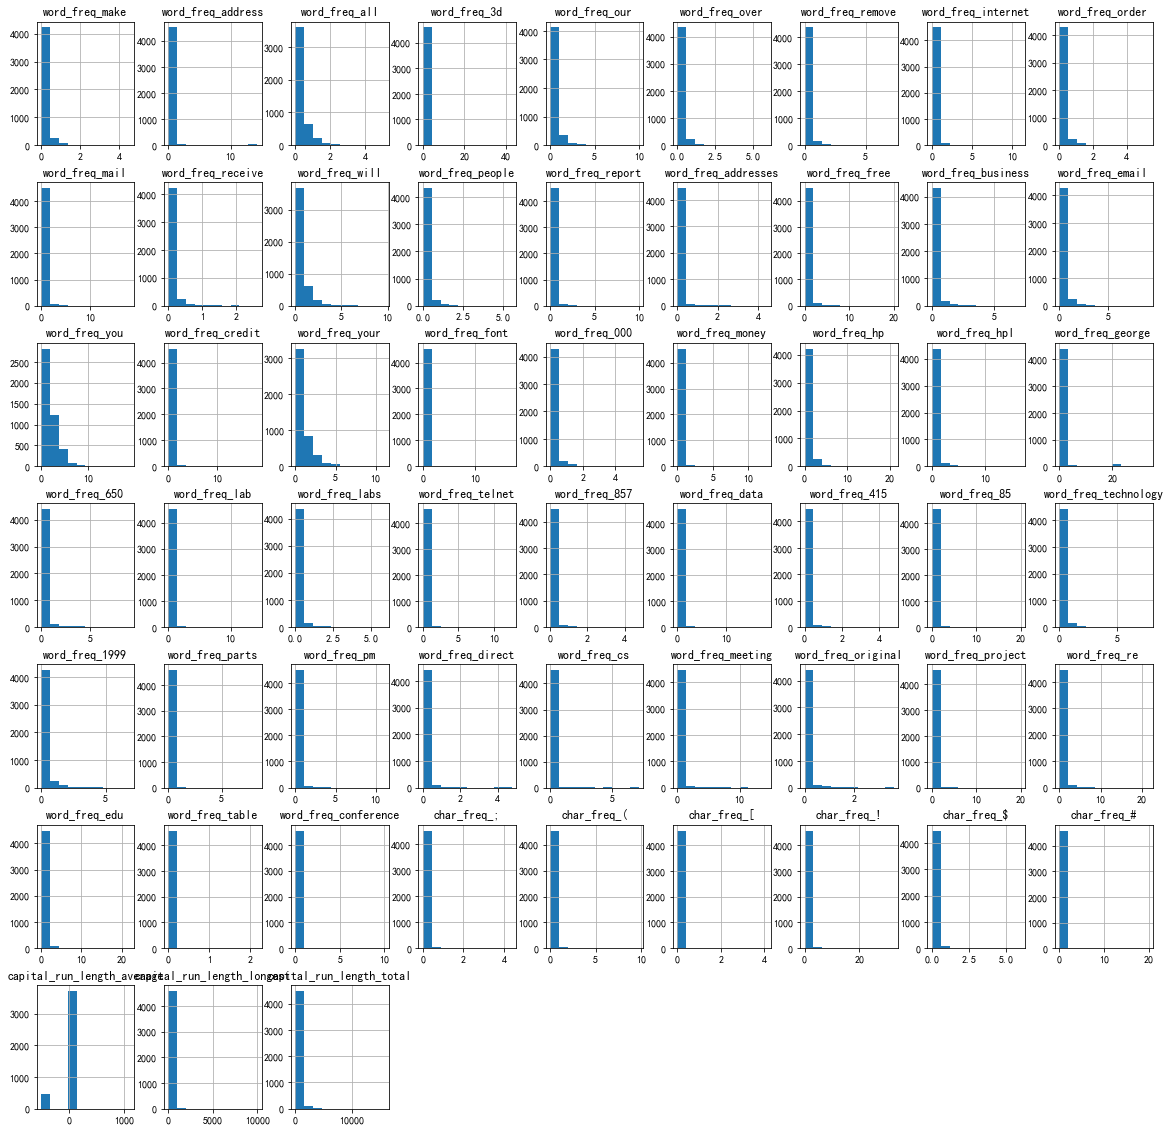

In [20]:
# plot histogram of all the numerical variables
merged_train_test.hist(figsize=(20, 20),layout=(7,9))
plt.show()

`capital_run_length_average` has a lot of negative values. set them as NA for next part of the problem.

In [21]:
dftr.loc[dftr['capital_run_length_average']<0,'capital_run_length_average'] = np.nan
dfte.loc[dfte['capital_run_length_average']<0,'capital_run_length_average'] = np.nan

### Impute missing value

- Training: train a $k$-nearest neighbors regressor on subset of training set which doesn't have missing values

- Prediction: impute the missing/outlier values in the `capital_run_length_average` column in both training set and test set

- Standardization: Both training and prediction will use mean and SD from training set to standardize training set and test set.

- After imputation, standardize both training set and test set by mean and SD from imputed training set.

In [25]:
# Split off the `spam` column from the training set into a new vector called `ytrain`
ytrain = dftr['spam']

# drop `spam` column from the training dataframe. 
dftr = dftr.drop('spam',axis=1)

def standardknn(xtrain,ytrain,m=0,s=1,k=15):
    """KNN regression with standardized input"""
    knnfit = neighbors.KNeighborsRegressor(k).fit((xtrain-m)/s,ytrain)
    return lambda x: knnfit.predict((x-m)/s)

# row index of row with missing value in training set
nainds = dftr['capital_run_length_average'].isna()
# row index of row with no missing value
goodinds = ~nainds
# row index of row with missing value in test set
naindstest = dfte['capital_run_length_average'].isna()

# calculate mean and SD of training set 
m = dftr.drop(['capital_run_length_average'],axis=1).mean()
s = dftr.drop(['capital_run_length_average'],axis=1).std()

training_no_na = dftr[goodinds].drop(['capital_run_length_average'],axis=1)
labels_no_na = dftr[goodinds]['capital_run_length_average']

# training KNN regressor by training set
myknn = standardknn(training_no_na,labels_no_na,m=m,s=s)

# Prediction: impute missing value in both training set and test set
dftr.loc[nainds,'capital_run_length_average'] = myknn(dftr[nainds].drop(['capital_run_length_average'],axis=1))
dfte.loc[naindstest,'capital_run_length_average'] = myknn(dfte[naindstest].drop(['capital_run_length_average'],axis=1))

# standardization again by mean and SD from imputed training set
m=dftr.mean()
s=dftr.std()
dftr = (dftr-m)/s
dfte = (dfte-m)/s

In [29]:
# after standardization , column mean of training set should all be 0s, while test set is close to 0
pd.concat([np.mean(dftr),np.mean(dfte)],axis=1,sort=False, keys=['Train', 'Test'])

,Train,Test
word_freq_make,1.623116e-17,-0.050198
word_freq_address,-1.527638e-17,0.044487
word_freq_all,-5.919598e-17,-0.006231
word_freq_3d,4.773869e-18,-0.049579
word_freq_our,-1.207789e-16,0.083350
word_freq_over,1.336683e-17,0.018618
word_freq_remove,2.291457e-17,0.028737
word_freq_internet,-3.819096e-18,-0.044006
word_freq_order,1.909548e-17,0.059460
word_freq_mail,-1.432161e-18,0.020024


## KNN classification by different k

Write a function named `knnlearn()` that performs $k$-nearest neighbors classification along with some additional behavior.

-  automatically do a split of the training data into a sub-training set (80%) and a validation set (20%) for selecting the optimal $k$.

- standardize each column: for a particular variable, say `x1`, compute the mean and standard deviation of `x1` **using the training set only**, say `mu1` and `s1`; 

    then for each observed column in the training set and test set, subtract the respective `mu` and divide by the respective `s`. 

In [35]:
def knnlearn(xtrain, xtest,ytrain, ktotry):
    """
    standardizes and does nearest neighbors as well as picks the best k based on the xtrain_val behavior
    """
    train_error = np.zeros(len(ktotry))
    val_error = np.zeros(len(ktotry))
    
    # randomly split training set into 80% sub-training set and 20% validation set 
    ntrain = xtrain.shape[0]
    trainbools = np.array([True]*round(ntrain*0.8) + [False]*(ntrain - round(ntrain*0.8)))
    np.random.shuffle(trainbools)
    
    # standardization: scale both training set and test set by mean and sd of training set
    m = xtrain.mean()
    s = xtrain.std()
    xtrain = (xtrain - m)/s
    xtest = (xtest-m)/s

    xtrain_train = xtrain.iloc[trainbools,:]
    xtrain_val = xtrain.iloc[~trainbools,:]
    ytrain_train = ytrain.iloc[trainbools]
    ytrain_val = ytrain.iloc[~trainbools]

    for i, k in enumerate(ktotry):
        fitted = neighbors.KNeighborsClassifier(k).fit(xtrain_train, ytrain_train)
        train_error[i] = np.sum((fitted.predict(xtrain_train)-ytrain_train)**2)/xtrain_train.shape[0]
        val_error[i] = np.mean((fitted.predict(xtrain_val)-ytrain_val)**2)
    
    optim_k = max(ktotry[np.argmin(val_error)], 3)
    model = neighbors.KNeighborsClassifier(optim_k).fit(xtrain,ytrain)
    yhat_test = model.predict(xtest)
    
    return train_error, val_error

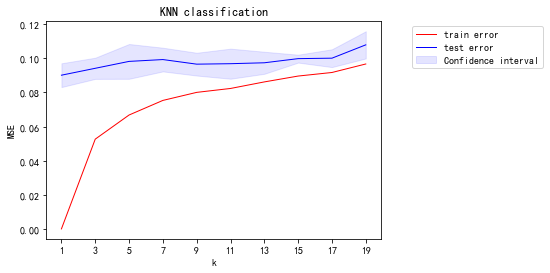

In [40]:
def knnTrials(xtrain,xtest,ytrain, TRIALS=5):
    ktotry = np.arange(1,20,2)
    testerror = np.zeros((TRIALS, len(ktotry)))
    trainerror = np.zeros((TRIALS, len(ktotry)))
    for j in range(TRIALS):
        trainerror[j], testerror[j] = knnlearn(xtrain,xtest,ytrain, ktotry)


    plt.plot(ktotry, np.mean(trainerror,axis=0),color='red',label='train error',linewidth=1)
    plt.plot(ktotry, np.mean(testerror,axis=0),color='blue',label='test error',linewidth=1)
    # confidence interval
    m, sd = np.mean(testerror,axis=0), np.std(testerror,axis=0)
    plt.fill_between(ktotry, m-sd, m+sd, color='b', alpha=.1, label='Confidence interval')

    plt.legend(bbox_to_anchor=(1.5, 1))
    plt.xlabel("k")
    plt.xticks(ktotry)
    plt.ylabel("MSE")
    plt.title("KNN classification")

knnTrials(dftr,dfte,ytrain)

# Newton's Methods to solve Logistic Regression

Linear regression has a closed form solution: $\hat{\beta} = (X^T X)^{-1} X^T y$. 

There is no such closed form solution for logistic regression (when $y_i \in \{0,1\}$). 

$$
\hat{\beta} = \arg \min_{\beta} f(\beta) = \arg \min_{\beta}\frac{1}{n} \sum_{i=1}^n -y_i x_i^T \beta + \log(1+\exp(x_i^T \beta))
$$

one method is an interative method called Newton's method where we start with $\beta_0 = 0$ and update based on
$$
\beta_{k+1} = \beta_k - [H f(\beta_k)]^{-1} \nabla f(\beta_k)
$$
where
$$
[H f(\beta_k)]_{ij} = \frac{\partial^2 f(\beta_k)}{\partial_i \partial_j}
$$
is Hessian matrix of second derivatives

In [58]:
def logreg(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    input
    X: data. shape (n, p)
    y: binary label of 0 and 1 of shape (n, )
    output
    B: weight. shape (p, 100) where the ith column is beta_i.
    By definition the first column of B should be all zeros.
    """
    n,p = X.shape 
    assert n==y.shape[0]
    ITER = 100
    B = np.zeros((p,ITER))
    for k in range(1,ITER):
        p = 1/(1+np.exp(-X@B[:,k-1]))     # sigmoid function of X @ B_j
        H = X.T @ np.diag(p*(k-p)) @ X/n  # Hessian
        grad = 1/n * X.T @ (p-y)            # gradient
        B[:,k] = B[:,k-1] - np.linalg.inv(H) @ grad   # update weight
    
    return B

Generate simulated data to test the code. 

Take $p=5$ and $n=1000$. 

Plot the log of estimation error for each iteration of weight $\beta_k$. 

$$
e_k = \| \beta_k - \beta^* \|_2^2
$$.

Text(0.5, 1.0, "Newton's method for solving Logistic regression")

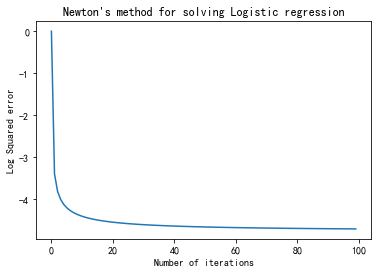

In [59]:
n=1000
p=5
betastar = np.ones(5)/np.sqrt(5)
X = np.random.randn(n,p)
y = np.random.rand(n) < 1 / (1 + np.exp(- X @ betastar)) 
hatB = logreg(X,y)
clf = LogisticRegression(random_state=0,penalty='none',fit_intercept=False,solver='newton-cg').fit(X, y)
np.isclose(clf.coef_[0],  hatB[:,-1])

e = np.sum((hatB - betastar[:,None])**2,axis=0)

plt.plot(np.log(e))
plt.xlabel("Number of iterations")
plt.ylabel("Log Squared error")
plt.title("Newton's method for solving Logistic regression")